In [67]:
# ================================
# Install dependencies
# ================================
%pip install --quiet yfinance pandas numpy scikit-learn tensorflow


In [68]:

# -----------------------------
# Imports
# -----------------------------
import os
import json
import concurrent.futures
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
from tqdm import tqdm
import inspect

# -----------------------------
# Parameters
# -----------------------------
SEQ_LEN = 30
EPOCHS = 20
BATCH_SIZE = 32
MAX_WORKERS = 8
DATA_HISTORY_IN_YEARS = 20
DATA_INTERVAL_IN_DAYS = 1
DATA_DIR = "data"
FEATURES = ["Open", "High", "Low", "Close", "Volume"]
MODEL_NAME = "nifty100_hybrid_model_v3.keras"
DATA_DICT_FILE = "data_dict.json"
os.makedirs(DATA_DIR, exist_ok=True)


In [69]:

# -----------------------------
# Training Stocks
# -----------------------------
symbols = [
    "ADANIPORTS.NS", "ASIANPAINT.NS", "AXISBANK.NS", "BAJAJ-AUTO.NS", "BAJFINANCE.NS",
    "BAJAJFINSV.NS", "BPCL.NS", "BHARTIARTL.NS", "BRITANNIA.NS", "CIPLA.NS",
    "COALINDIA.NS", "DRREDDY.NS", "EICHERMOT.NS", "GAIL.NS", "GRASIM.NS",
    "HCLTECH.NS", "HDFCBANK.NS", "HDFCLIFE.NS", "ICICIBANK.NS", "INDUSINDBK.NS",
    "INFY.NS", "ITC.NS", "JSWSTEEL.NS", "KOTAKBANK.NS", "LT.NS",
    "M&M.NS", "MARUTI.NS", "NTPC.NS", "NESTLEIND.NS", "ONGC.NS",
    "POWERGRID.NS", "RELIANCE.NS", "SBILIFE.NS", "SBIN.NS", "SUNPHARMA.NS",
    "TCS.NS", "TATACONSUM.NS", "TATASTEEL.NS", "TECHM.NS", "TITAN.NS",
    "ULTRACEMCO.NS", "UPL.NS", "WIPRO.NS", "DIVISLAB.NS"
]

# Mapping NSE stocks → Sector Index (Yahoo Finance symbols)
SECTOR_INDEX_MAP = {
    "TCS.NS": "^CNXIT",        # Nifty IT
    "INFY.NS": "^CNXIT",
    "WIPRO.NS": "^CNXIT",
    "TECHM.NS": "^CNXIT",

    "HDFCBANK.NS": "^NSEBANK", # Nifty Bank
    "ICICIBANK.NS": "^NSEBANK",
    "KOTAKBANK.NS": "^NSEBANK",
    "AXISBANK.NS": "^NSEBANK",
    "SBIN.NS": "^NSEBANK",

    "RELIANCE.NS": "^CNXENERGY", # Nifty Energy
    "ONGC.NS": "^CNXENERGY",
    "BPCL.NS": "^CNXENERGY",
    "POWERGRID.NS": "^CNXENERGY",
    "NTPC.NS": "^CNXENERGY",

    # default fallback → Nifty 50 itself
}

FEATURES_SEQ = [
    "Open", "High", "Low", "Close", "Volume", "Return", "MA7", "MA21",
    "STD21", "Upper_BB", "Lower_BB", "EMA", "Momentum", "RSI",
    "MACD", "MACD_Signal", "ATR"
]

FEATURES_STATIC = ["EPS", "NIFTY", "VIX", "^NSEI_INDEX"]



In [70]:
# -----------------------------
# Data Fetcher (cached download)
# -----------------------------

def fetch_stock(sym):
    file_path = os.path.join(DATA_DIR, f"{sym}.csv")

    if os.path.exists(file_path):
        # Load existing CSV
        df_existing = pd.read_csv(file_path, parse_dates=["Date"])

        # Find the last available date
        last_date = df_existing["Date"].max()

        start_date = (last_date + pd.Timedelta(days=1)).strftime("%Y-%m-%d")

        # if start_date is greater than today then return existing df
        if pd.to_datetime(start_date) > pd.to_datetime("today"):
            return sym, df_existing


        # Fetch new data starting from the day after last_date
        df_new = yf.download(
            sym,
            start=(last_date + pd.Timedelta(days=1)).strftime("%Y-%m-%d"),
            interval=f"{DATA_INTERVAL_IN_DAYS}d"
        )

        if not df_new.empty:
            df_new = df_new[FEATURES].dropna()

            # Flatten MultiIndex if present
            if isinstance(df_new.columns, pd.MultiIndex):
                df_new.columns = df_new.columns.get_level_values(0)

            df_new = df_new.reset_index()

            # Append only new rows
            df_combined = pd.concat([df_existing, df_new], ignore_index=True)
            df_combined = df_combined.drop_duplicates(subset=["Date"]).reset_index(drop=True)

            # Save updated CSV
            df_combined.to_csv(file_path, index=False)
            return sym, df_combined

        # If no new data, return existing
        return sym, df_existing

    else:
        # No CSV yet — fetch full history
        df = yf.download(
            sym,
            period=f"{DATA_HISTORY_IN_YEARS}y",
            interval=f"{DATA_INTERVAL_IN_DAYS}d"
        )
        if df.empty:
            return sym, None

        df = df[FEATURES].dropna()

        if isinstance(df.columns, pd.MultiIndex):
            df.columns = df.columns.get_level_values(0)

        df = df.reset_index()
        df.to_csv(file_path, index=False)
        return sym, df

# -----------------------------
# Extra Data Fetchers (for India)
# -----------------------------
def fetch_macro_data():
    """Fetch Nifty 50 Index and India VIX as macro indicators"""
    # Nifty 50 index (^NSEI) and India VIX (^INDIAVIX) are available on Yahoo Finance
    nifty = yf.download("^NSEI", period=f"{DATA_HISTORY_IN_YEARS}y", interval=f"{DATA_INTERVAL_IN_DAYS}d")
    vix = yf.download("^INDIAVIX", period=f"{DATA_HISTORY_IN_YEARS}y", interval=f"{DATA_INTERVAL_IN_DAYS}d")

    # Keep only Close prices
    nifty = nifty[["Close"]].rename(columns={"Close": "NIFTY"})
    vix = vix[["Close"]].rename(columns={"Close": "VIX"})

    # Reset index to Date
    nifty = nifty.reset_index()[["Date", "NIFTY"]]
    vix = vix.reset_index()[["Date", "VIX"]]

    # Merge
    macro = pd.merge(nifty, vix, on="Date", how="outer").sort_values("Date")

    # Flatten MultiIndex if present
    if isinstance(macro.columns, pd.MultiIndex):
        macro.columns = macro.columns.get_level_values(0)

    return macro

def fetch_fundamentals(symbol):
    """Fetch quarterly EPS from Yahoo Finance fundamentals"""
    ticker = yf.Ticker(symbol)
    try:
        financials = ticker.quarterly_financials.T  # transpose → rows=quarters
        eps = financials["Net Income"] / ticker.quarterly_financials.loc["Basic Average Shares"].T
        eps = eps.reset_index()
        eps = eps.rename(columns={"index": "Date", 0: "EPS"})
        eps["Date"] = pd.to_datetime(eps["Date"])
        return eps[["Date", "EPS"]]
    except Exception:
        # fallback if data missing
        return pd.DataFrame(columns=["Date", "EPS"])


# -----------------------------
# Updated Feature Engineering
# -----------------------------
def add_features(df: pd.DataFrame, fundamentals=None, macro=None, drop_date=False, sector=None):
    df = df.copy()

    # Technical indicators
    df["Return"] = df["Close"].pct_change()
    df["MA7"] = df["Close"].rolling(7).mean()
    df["MA21"] = df["Close"].rolling(21).mean()
    df["STD21"] = df["Close"].rolling(21).std()
    df["Upper_BB"] = df["MA21"] + (df["STD21"] * 2)
    df["Lower_BB"] = df["MA21"] - (df["STD21"] * 2)
    df["EMA"] = df["Close"].ewm(span=20, adjust=False).mean()
    df["Momentum"] = df["Close"] - df["Close"].shift(5)

    # --- RSI (Relative Strength Index, 14-day) ---
    delta = df["Close"].diff()
    gain = (delta.where(delta > 0, 0)).rolling(14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(14).mean()
    rs = gain / (loss + 1e-9)
    df["RSI"] = 100 - (100 / (1 + rs))

    # --- MACD (12,26) & Signal (9) ---
    ema12 = df["Close"].ewm(span=12, adjust=False).mean()
    ema26 = df["Close"].ewm(span=26, adjust=False).mean()
    df["MACD"] = ema12 - ema26
    df["MACD_Signal"] = df["MACD"].ewm(span=9, adjust=False).mean()

    # --- ATR (Average True Range, 14-day) ---
    high_low = df["High"] - df["Low"]
    high_close = (df["High"] - df["Close"].shift()).abs()
    low_close = (df["Low"] - df["Close"].shift()).abs()
    tr = high_low.to_frame("hl").join(high_close.to_frame("hc")).join(low_close.to_frame("lc")).max(axis=1)
    df["ATR"] = tr.rolling(14).mean()

    # Merge fundamentals (EPS quarterly)
    if fundamentals is not None and not fundamentals.empty:
        df = pd.merge(df, fundamentals, on="Date", how="left")
        # Handle duplicate EPS columns if merge creates EPS_x / EPS_y
        if "EPS" in df.columns:
            df["EPS"] = df["EPS"].ffill().bfill()
        elif "EPS_x" in df.columns and "EPS_y" in df.columns:
            df["EPS"] = df["EPS_x"].combine_first(df["EPS_y"])
            df.drop(columns=["EPS_x", "EPS_y"], inplace=True)
        elif "EPS" not in df.columns:   # ensure EPS exists
            df["EPS"] = np.nan
        df["EPS"] = df["EPS"].ffill()

    # Merge macro data (Nifty + VIX)
    if macro is not None and not macro.empty:
        df = pd.merge(df, macro, on="Date", how="left")

        # List of macro columns to handle
        macro_cols = ["NIFTY", "VIX"]

        for col in macro_cols:
            col_x, col_y = f"{col}_x", f"{col}_y"

            if col in df.columns:
                df[col] = df[col].ffill().bfill()

            elif col_x in df.columns and col_y in df.columns:
                df[col] = df[col_x].combine_first(df[col_y])
                df.drop(columns=[col_x, col_y], inplace=True)

            elif col not in df.columns:
                df[col] = np.nan

        # Forward-fill all handled macro columns
        df[macro_cols] = df[macro_cols].ffill()


    # -----------------------------
    # Sector Index (optional, e.g., NIFTY IT for TCS)
    # -----------------------------
    if sector is not None:
        sector_data = yf.download(sector, period=f"{DATA_HISTORY_IN_YEARS}y", interval=f"{DATA_INTERVAL_IN_DAYS}d")[["Close"]]

        # Flatten MultiIndex if needed
        if isinstance(sector_data.columns, pd.MultiIndex):
            sector_data.columns = sector_data.columns.get_level_values(0)

        sector_data = sector_data.reset_index().rename(columns={"Close": f"{sector}_INDEX"})

        df = pd.merge(df, sector_data, on="Date", how="left")
        if f"{sector}_INDEX" in df.columns:
                df[f"{sector}_INDEX"] = df[f"{sector}_INDEX"].ffill().bfill()
        elif f"{sector}_INDEX_x" in df.columns and f"{sector}_INDEX_y" in df.columns:
            df[f"{sector}_INDEX"] = df[f"{sector}_INDEX_x"].combine_first(df[f"{sector}_INDEX_y"])
            df.drop(columns=[f"{sector}_INDEX_x", f"{sector}_INDEX_y"], inplace=True)
        elif f"{sector}_INDEX" not in df.columns:   # ensure EPS exists
            df[f"{sector}_INDEX"] = np.nan
        df[f"{sector}_INDEX"] = df[f"{sector}_INDEX"].ffill()

    # Fill missing values instead of dropping most rows
    # df = df.ffill().bfill()

    if drop_date:
        df = df.drop(columns=["Date"])

    return df.dropna()

# -----------------------------
# Sequence Creator
# -----------------------------
def create_sequences(data, seq_len=SEQ_LEN, split=0.8):
    """
    data: full feature array (scaled)
    Assumes last 4 columns = EPS, NIFTY, VIX, Sector Index (static features)
    """

    X_seq, X_static, y = [], [], []

    # Assuming the order of FEATURES_SEQ + FEATURES_STATIC in df after adding features
    # The last 4 columns are EPS, NIFTY, VIX, and Sector Index
    data_seq = data[:, :len(FEATURES_SEQ)]
    data_static = data[:, len(FEATURES_SEQ):]
    target = data[:, 3] # Assuming 'Close' is the 4th column (index 3)

    for i in range(seq_len, len(data)):
        X_seq.append(data_seq[i-seq_len:i])
        X_static.append(data_static[i])
        y.append(target[i])

    X_seq = np.array(X_seq)
    X_static = np.array(X_static)
    y = np.array(y).reshape(-1, 1)

    split_idx = int(len(X_seq) * split)
    return (X_seq[:split_idx], X_static[:split_idx], y[:split_idx]), (X_seq[split_idx:], X_static[split_idx:], y[split_idx:])

# -----------------------------
# Build Model
# -----------------------------
def build_model(input_shape):
    model = Sequential([
        LSTM(128, return_sequences=True, input_shape=input_shape),
        Dropout(0.4),
        LSTM(64),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer=Adam(0.001), loss=Huber())
    return model

# -----------------------------
# Training Pipeline
# -----------------------------

def save_data_dict(data_dict, file_path=DATA_DICT_FILE):
    # Convert DataFrames to a JSON-friendly format (dictionary of lists)
    json_data_dict = {}
    for symbol, df in data_dict.items():
        # Convert DataFrame to dictionary of lists, handling datetimes
        json_data_dict[symbol] = df.to_dict(orient='list')
        # Convert datetime objects to strings for JSON compatibility
        if 'Date' in json_data_dict[symbol]:
            json_data_dict[symbol]['Date'] = [str(date) for date in json_data_dict[symbol]['Date']]
    # Dump the dictionary to a JSON file
    with open(file_path, "w") as f:
        json.dump(json_data_dict, f, indent=4)
    print(f"✅ Saved updated data_dict to {file_path}")

def load_data_dict(file_path=DATA_DICT_FILE):
    if not os.path.exists(file_path):
        return {}
    with open(file_path, "r") as f:
        loaded = json.load(f)
    data_dict = {}
    for sym, data in loaded.items():
        df = pd.DataFrame(data)
        if "Date" in df.columns:
            df["Date"] = pd.to_datetime(df["Date"])
        data_dict[sym] = df
    print(f"✅ Loaded existing data_dict from {file_path}")
    return data_dict

# -----------------------------
# Update Data Dictionary
# -----------------------------
def update_data_dict(symbols):
    data_dict = load_data_dict()
    macro = fetch_macro_data()  # fetch once for all stocks

    with concurrent.futures.ProcessPoolExecutor(max_workers=MAX_WORKERS) as executor:
        results = list(tqdm(executor.map(fetch_stock, symbols), total=len(symbols), desc="Fetching data"))

    for sym, df in results:
        if df is not None:
            # Fetch EPS for this stock
            fundamentals = fetch_fundamentals(sym)
            sector_index = SECTOR_INDEX_MAP.get(sym, "^NSEI")

            if sym in data_dict:
                df_existing = data_dict[sym]
                df_combined = pd.concat([df_existing, df], ignore_index=True)
                df_combined = df_combined.drop_duplicates(subset=["Date"]).reset_index(drop=True)
                data_dict[sym] = add_features(df_combined, fundamentals=fundamentals, macro=macro, sector= sector_index)
            else:
                data_dict[sym] = add_features(df, fundamentals=fundamentals, macro=macro, sector= sector_index)

    save_data_dict(data_dict)
    return data_dict

In [54]:
data_dict = update_data_dict(symbols)

/tmp/ipython-input-2026733435.py:74: FutureWarning: YF.download() has changed argument auto_adjust default to True
  nifty = yf.download("^NSEI", period=f"{DATA_HISTORY_IN_YEARS}y", interval=f"{DATA_INTERVAL_IN_DAYS}d")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-2026733435.py:75: FutureWarning: YF.download() has changed argument auto_adjust default to True
  vix = yf.download("^INDIAVIX", period=f"{DATA_HISTORY_IN_YEARS}y", interval=f"{DATA_INTERVAL_IN_DAYS}d")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-2026733435.py:86: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  macro = pd.merge(nifty, vix, on="Date", how="outer").sort_values("Date")
Fetching data:   0%|          | 0/44 [00:00<?, ?it/s]/tmp/ipython-input-2026733435.py:51: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(
/tmp/ipyth

✅ Saved updated data_dict to data_dict.json


In [55]:

# -----------------------------
# Build Model
# -----------------------------

from tensorflow.keras.layers import Input, LSTM, Dropout, Dense, Concatenate, Flatten
from tensorflow.keras.models import Model

def build_hybrid_model(seq_shape, static_shape):
    """
    seq_shape: (SEQ_LEN, n_seq_features)   e.g. (20, 10)
    static_shape: (n_static_features,)     e.g. (3,) -> EPS, NIFTY, VIX
    """

    # --- Sequential (time-series) branch ---
    seq_input = Input(shape=seq_shape, name="seq_input")
    x = LSTM(128, return_sequences=True)(seq_input)
    x = Dropout(0.3)(x)
    x = LSTM(64)(x)
    x = Dropout(0.2)(x)

    # --- Static (fundamentals + macro) branch ---
    static_input = Input(shape=static_shape, name="static_input")
    y = Dense(64, activation="relu")(static_input)
    y = Dropout(0.2)(y)
    y = Dense(32, activation="relu")(y)

    # --- Merge branches ---
    merged = Concatenate()([x, y])
    z = Dense(64, activation="relu")(merged)
    z = Dropout(0.2)(z)
    output = Dense(1)(z)

    model = Model(inputs=[seq_input, static_input], outputs=output)
    model.compile(optimizer=Adam(0.001), loss=Huber())

    return model


In [56]:
scaler_dict, scaled_data_dict = {}, {}
for sym, df in data_dict.items():
    df = df.drop(columns=["Date"])
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(df)
    scaler_dict[sym] = scaler
    scaled_data_dict[sym] = scaled

In [57]:

# -----------------------------
# Fit or Train the model
# -----------------------------

# Prepare training data
X_seq_train_list, X_static_train_list, y_train_list = [], [], []
X_seq_test_list, X_static_test_list, y_test_list = [], [], []

for scaled in scaled_data_dict.values():
    (X_seq_tr, X_static_tr, y_tr), (X_seq_te, X_static_te, y_te) = create_sequences(scaled, SEQ_LEN)
    X_seq_train_list.append(X_seq_tr); X_static_train_list.append(X_static_tr); y_train_list.append(y_tr)
    X_seq_test_list.append(X_seq_te);  X_static_test_list.append(X_static_te);  y_test_list.append(y_te)

X_seq_train, X_static_train, y_train = np.vstack(X_seq_train_list), np.vstack(X_static_train_list), np.vstack(y_train_list)
X_seq_test, X_static_test, y_test = np.vstack(X_seq_test_list), np.vstack(X_static_test_list), np.vstack(y_test_list)

# Build model
model = build_hybrid_model((SEQ_LEN, X_seq_train.shape[2]), (X_static_train.shape[1],))

early_stopping = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-4, verbose=1)

# Train
history = model.fit(
    {"seq_input": X_seq_train, "static_input": X_static_train},
    y_train,
    validation_split=0.2,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping, lr_scheduler]
)

# -----------------------------
# Save Model
# -----------------------------

model.save(MODEL_NAME)

Epoch 1/20
4125/4125 ━━━━━━━━━━━━━━━━━━━━ 298s 71ms/step - loss: 7.6809e-04 - val_loss: 1.3949e-04 - learning_rate: 0.0010
Epoch 2/20
4125/4125 ━━━━━━━━━━━━━━━━━━━━ 319s 70ms/step - loss: 2.7453e-04 - val_loss: 3.5564e-05 - learning_rate: 0.0010
Epoch 3/20
4125/4125 ━━━━━━━━━━━━━━━━━━━━ 344s 76ms/step - loss: 2.3750e-04 - val_loss: 2.8612e-05 - learning_rate: 0.0010
Epoch 4/20
4125/4125 ━━━━━━━━━━━━━━━━━━━━ 321s 75ms/step - loss: 2.1637e-04 - val_loss: 7.1283e-05 - learning_rate: 0.0010
Epoch 5/20
4124/4125 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 2.1320e-04
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
4125/4125 ━━━━━━━━━━━━━━━━━━━━ 290s 70ms/step - loss: 2.1319e-04 - val_loss: 2.6333e-05 - learning_rate: 0.0010
Epoch 6/20
4125/4125 ━━━━━━━━━━━━━━━━━━━━ 343s 75ms/step - loss: 1.8551e-04 - val_loss: 5.2044e-05 - learning_rate: 5.0000e-04
Epoch 7/20
4125/4125 ━━━━━━━━━━━━━━━━━━━━ 323s 76ms/step - loss: 1.8498e-04 - val_loss: 5.5576e-05 - learning_rate: 5.0

In [58]:
# -----------------------------
# Evaluate
# -----------------------------
# model = load_model(MODEL_NAME, compile=False)

y_pred = model.predict(
    {"seq_input": X_seq_test, "static_input": X_static_test},
    verbose=0
)

# fix RMSE for old sklearn
if "squared" in inspect.signature(mean_squared_error).parameters:
    rmse = mean_squared_error(y_test, y_pred, squared=False)
else:
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")


RMSE: 0.0129, MAE: 0.0092, R²: 0.9953


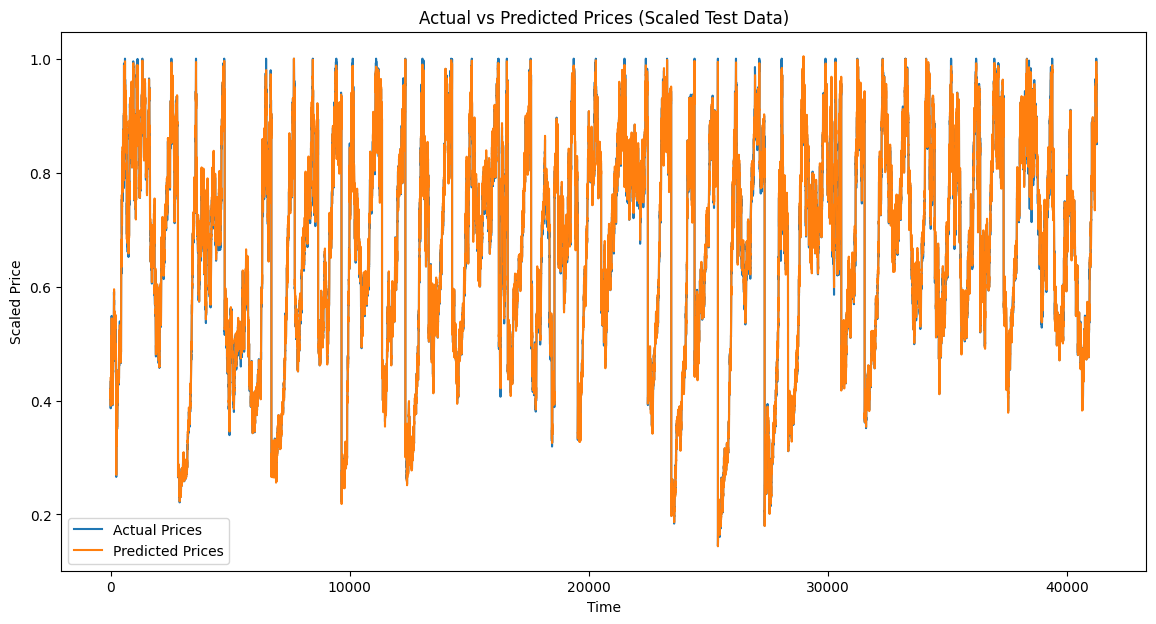

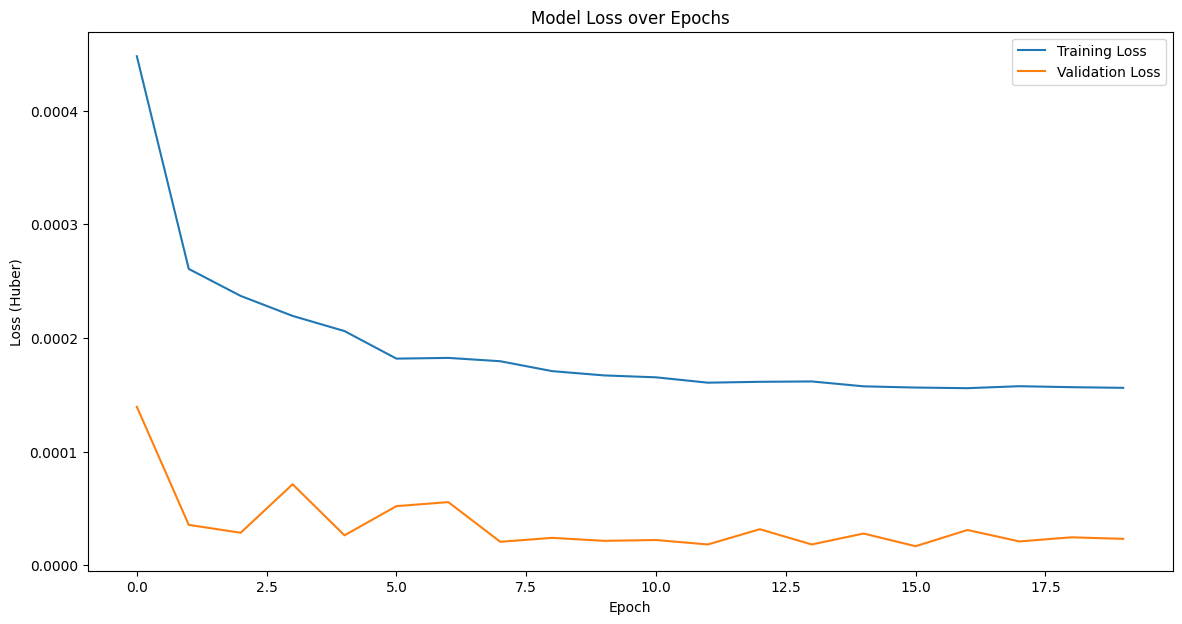

In [74]:
# -----------------------------
# Visualize Results
# -----------------------------

# Plot actual vs predicted prices
plt.figure(figsize=(14, 7))
plt.plot(y_test, label="Actual Prices")
plt.plot(y_pred, label="Predicted Prices")
plt.title("Actual vs Predicted Prices (Scaled Test Data)")
plt.xlabel("Time")
plt.ylabel("Scaled Price")
plt.legend()
plt.show()

# Plot training and validation loss
plt.figure(figsize=(14, 7))
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Model Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss (Huber)")
plt.legend()
plt.show()

In [65]:
def predict_stock(symbol, model_path=MODEL_NAME):
    model = load_model(model_path, compile=False)

    sym, df = fetch_stock(symbol)
    if df is None:
        print(f"❌ No data for {symbol}")
        return None

    # Add features (already merges fundamentals + macro)
    fundamentals = fetch_fundamentals(sym)
    macro = fetch_macro_data()

    # Find relevant sector index
    sector_index = SECTOR_INDEX_MAP.get(symbol, "^NSEI")  # fallback to Nifty 50
    df_features = add_features(df, fundamentals=fundamentals, macro=macro, sector=sector_index, drop_date=True)

    # rename df_features sector inde column to NSEI_Index
    df_features.rename(columns={f"{sector_index}_INDEX": "^NSEI_INDEX"}, inplace=True)

    recent_data = df_features.tail(200)
    scaler = MinMaxScaler()
    scaled_recent = scaler.fit_transform(recent_data)

    # Find indices for seq and static columns
    col_index_map = {c: i for i, c in enumerate(df_features.columns)}
    seq_indices = [col_index_map[c] for c in FEATURES_SEQ]
    static_indices = [col_index_map[c] for c in FEATURES_STATIC]

    # Last SEQ_LEN for sequential
    X_seq = scaled_recent[-SEQ_LEN:, seq_indices].reshape(1, SEQ_LEN, len(seq_indices))
    # Last row for static
    X_static = scaled_recent[-1, static_indices].reshape(1, -1) # Correctly select static features

    pred_scaled = model.predict({"seq_input": X_seq, "static_input": X_static}, verbose=0)[0][0]


    # Inverse transform (for Close price)
    last_row = scaled_recent[-1].copy()
    # Assuming 'Close' is the 4th feature in FEATURES_SEQ, which is at index 3
    close_index_in_features_seq = FEATURES_SEQ.index("Close")
    last_row[close_index_in_features_seq] = pred_scaled
    pred_actual = scaler.inverse_transform([last_row])[0, close_index_in_features_seq]

    return {
        "symbol": symbol,
        "last_close": float(df_features["Close"].iloc[-1]),
        "predicted_close": float(pred_actual),
        "sector_index": sector_index
    }

In [66]:
print(predict_stock("TCS.NS"))

/tmp/ipython-input-2026733435.py:74: FutureWarning: YF.download() has changed argument auto_adjust default to True
  nifty = yf.download("^NSEI", period=f"{DATA_HISTORY_IN_YEARS}y", interval=f"{DATA_INTERVAL_IN_DAYS}d")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-2026733435.py:75: FutureWarning: YF.download() has changed argument auto_adjust default to True
  vix = yf.download("^INDIAVIX", period=f"{DATA_HISTORY_IN_YEARS}y", interval=f"{DATA_INTERVAL_IN_DAYS}d")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-2026733435.py:86: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  macro = pd.merge(nifty, vix, on="Date", how="outer").sort_values("Date")
/tmp/ipython-input-2026733435.py:186: FutureWarning: YF.download() has changed argument auto_adjust default to True
  sector_data = yf.download(sector, period=f"{DATA_HISTORY_IN_YEARS}y", interval=f

{'symbol': 'TCS.NS', 'last_close': 3100.300048828125, 'predicted_close': 3045.7415992020246, 'sector_index': '^CNXIT'}
